In [63]:
# PyTorch GPU Acceleration
# PyTorch can offload tensor operations to the GPU for massive performance boosts.
# Small computations may be faster on CPU (due to data transfer overhead).
# Always ensure all tensors are on the same device (CPU or GPU).
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(2**11, 2**11).to(device)
y = x @ x  # Matrix multiplication


In [64]:
# Example: Benchmarking GPU vs CPU
import torch, timeit

x = torch.rand(2**11, 2**11)
time_cpu = timeit.timeit("x@x", globals=globals(), number=100)
print("CPU:", time_cpu)

device = torch.device("cuda")
x = x.to(device)
time_gpu = timeit.timeit("x@x", globals=globals(), number=100)
print("GPU:", time_gpu)


CPU: 13.14269556599993
GPU: 0.0018026490001830098


In [65]:
# Automatic Differentiation
import torch
x = torch.tensor([-3.5], requires_grad=True)
f = lambda x: (x - 2)**2

value = f(x)
value.backward()  # Compute derivative
print(x.grad)     # Prints gradient: -11.0


tensor([-11.])


In [66]:
# Minimizing a Function (Gradient Descent)
x = torch.tensor([-3.5], requires_grad=True)
eta = 0.1  # learning rate
epsilon = 1e-5
x_cur, x_prev = x.clone(), x.clone()*100

while torch.linalg.norm(x_cur - x_prev) > epsilon:
    x_prev = x_cur.clone()
    value = f(x)
    value.backward()
    x.data -= eta * x.grad
    x.grad.zero_()
    x_cur = x.data

print(x_cur)  # → tensor([2.0000])


tensor([2.0000])


In [67]:
# Using PyTorch’s Optimizers
x_param = torch.nn.Parameter(torch.tensor([-3.5]))
optimizer = torch.optim.SGD([x_param], lr=0.1)

for epoch in range(60):
    optimizer.zero_grad()
    loss = f(x_param)
    loss.backward()
    optimizer.step()

print(x_param.data)  # → tensor([2.0000])


tensor([2.0000])



Week 3 Activity:
#A: Neural Networks as Optimization
Linear Regression Example with Training Loop


In [68]:
# -----------------------------------------
# Week 3 Activity:
# A: Neural Networks as Optimization
# Linear Regression Example with Training Loop
# -----------------------------------------

import torch
import torch.nn as nn

#Create a simple dataset
# Relationship: y = 2x + 1
X = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
y = torch.tensor([[3.0], [5.0], [7.0], [9.0]])

#Define a simple model fΘ(x)
# nn.Linear represents fΘ(x) = Wx + b
model = nn.Linear(in_features=1, out_features=1)

#Define loss function (Mean Squared Error)
loss_fn = nn.MSELoss()

#Define optimizer (Stochastic Gradient Descent)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Function F(X, y, f) - total loss for all samples
def F(X, y, f):
    total_loss = 0
    N = X.shape[0]
    for i in range(N):
        y_pred = f(X[i])           # fΘ(xᵢ)
        total_loss += loss_fn(y_pred, y[i])  # l(fΘ(xᵢ), yᵢ)
    return total_loss

#Training loop (optimize Θ)
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()         # clear previous gradients
    total_loss = F(X, y, model)   # forward pass: compute total loss
    total_loss.backward()          # backward pass: compute gradients ▽Θ
    optimizer.step()              # update Θ ← Θ - α * ▽Θ

    # Print loss per epoch
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Loss = {total_loss.item():.6f}")

#After training
print("\nFinal Parameters (Θ):")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

#Test predictions
print("\nPredictions after training:")
with torch.no_grad():
    predictions = model(X)
    print(predictions)


Epoch   1 | Loss = 227.866882
Epoch  10 | Loss = 0.597858
Epoch  20 | Loss = 0.469841
Epoch  30 | Loss = 0.369236
Epoch  40 | Loss = 0.290173
Epoch  50 | Loss = 0.228040
Epoch  60 | Loss = 0.179211
Epoch  70 | Loss = 0.140837
Epoch  80 | Loss = 0.110680
Epoch  90 | Loss = 0.086981
Epoch 100 | Loss = 0.068356

Final Parameters (Θ):
weight: tensor([[2.1075]])
bias: tensor([0.6840])

Predictions after training:
tensor([[2.7914],
        [4.8989],
        [7.0064],
        [9.1139]])


#B.	Building a Linear Regression Model

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import sys
# Replace "My Drive/path/to/your/shared/folder" with the actual path to your shared folder shortcut
sys.path.append('/content/drive/MyDrive/week3')

In [71]:
!ls '/content/drive/MyDrive/week3'

 a1a.txt		 'Week03_LoadingDataset_Exercise.ipynb .ipynb'
 dlmam.py		  Week03_LoadingDataset.ipynb
 __pycache__		  Week03_NeuralNetworksII_Exercise.ipynb
 Week02_Exercises.ipynb   Week03_NeuralNetworksII.ipynb
 Week02_PyTorchII.ipynb


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from dlmam import *

In [73]:
def train_simple_network(model, loss_func, training_loader, \
                         epochs=20, device="cpu"):
  #Yellow step is done here. Creates the optimizer and moves the model
  #to compute device. SGD in the stochastic descent over the parameters
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  #places the model on the correct compute resource
  model.to(device)

  #The nested loop handle the red steps, iterating through all data (batches)
  #multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch"):

    model = model.train() #Puts our model in training mode
    running_loss = 0.0

    for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
      #Moves the batch of data to the device we are using.
      #This is the last red step.
      inputs = moveTo(inputs, device)
      labels = moveTo(labels, device)

      #First a yellow step: prepare the optimizer. Most PyTorch code
      #does this first to make sure everything is in a clean and
      #ready state. PyTorch stores gradients in a mutable data
      #structure, so we need to set it to a clean state before we use it.
      #Otherwise, it will have old information from a previous iteration.
      optimizer.zero_grad()

      #This line and the next perform the steps in blue section.
      y_hat = model(inputs)

      loss = loss_func(y_hat, labels)

      #The remaining two yellow steps compute the gradient and
      #“.step()” the optimizer. The call on this line computes
      #the gradient due to the parameters.
      loss.backward()

      optimizer.step() # Updates all the parameters

      running_loss += loss.item()#grabs information that we would like to have


<Axes: >

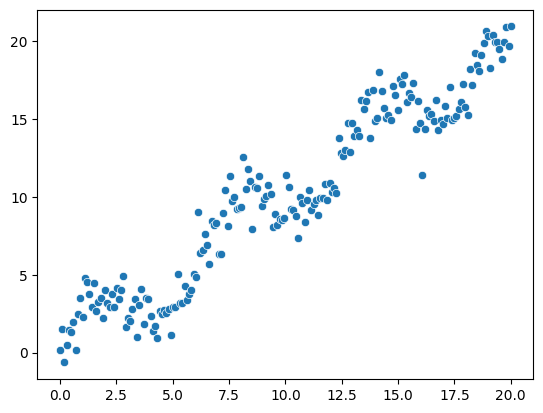

In [74]:
X = np.linspace(0, 20, num=200) #Creates one-dimensional input
y = X + np.sin(X)*2 + np.random.normal(size=X.shape) #Creates output
sns.scatterplot(x=X, y=y)


In [75]:
class Simple1DRegressionDataset(Dataset):

  def __init__(self, X, y):
    super(Simple1DRegressionDataset, self).__init__()
    self.X = X.reshape(-1,1)
    self.y = y.reshape(-1,1)

  def __getitem__(self, index):
    return torch.tensor(self.X[index,:], dtype=torch.float32),\
    torch.tensor(self.y[index], dtype=torch.float32)

  def __len__(self):
    return self.X.shape[0]

training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)


#C.	Defining the Model

In [76]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


In [77]:
model = LinearRegressionModel()
print(model)

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


#D.	Defining the Loss Function

In [78]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()
device = torch.device("cuda")

train_simple_network(model, loss_func, training_loader, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

<Axes: >

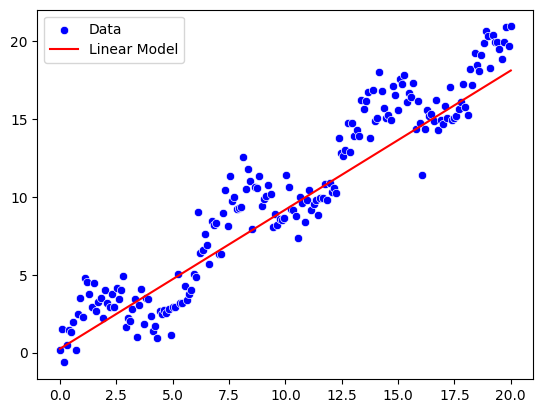

In [79]:
with torch.no_grad():
  Y_pred = model(torch.tensor(X.reshape(-1,1), device=device,\
                              dtype=torch.float32)).cpu().numpy()

#The data
sns.scatterplot(x=X, y=y, color='blue', label='Data')
#What the model learnt
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model')


#E.	Building Our first Neural Network

In [80]:
model = nn.Sequential( #Input “layer” is implicitly the input.
nn.Linear(1, 10), #Hidden layer
nn.Linear(10, 1), #Output layer
)

train_simple_network(model, loss_func, training_loader)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

<Axes: >

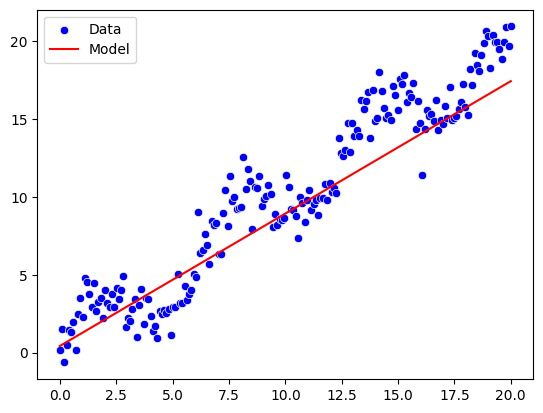

In [81]:

with torch.no_grad():
  #Shape of (N, 1)
  Y_pred = model(torch.tensor(X.reshape(-1,1), \
                              dtype=torch.float32)).cpu().numpy()

#The data
sns.scatterplot(x=X, y=y, color='blue', label='Data')
#What our model learned
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model')


#F.	Adding Nonlinearities

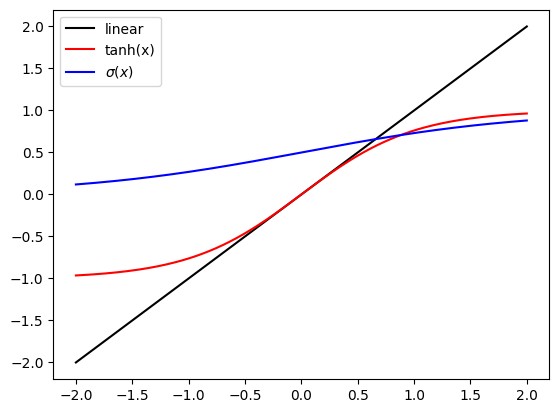

In [82]:

activation_input = np.linspace(-2, 2, num=200)

tanh_activation = np.tanh(activation_input)
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input)+1)

sns.lineplot(x=activation_input, y=activation_input, \
             color='black', label="linear")
sns.lineplot(x=activation_input, y=tanh_activation, \
             color='red', label="tanh(x)")
ax = sns.lineplot(x=activation_input, y=sigmoid_activation, \
                  color='blue', label="$σ(x)$")


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

<Axes: >

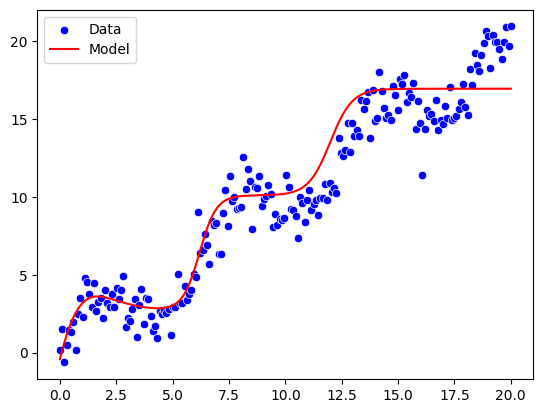

In [83]:
#Define and train the model
model = nn.Sequential(
  nn.Linear(1, 10), #Hidden layer
  nn.Tanh(), #Activation
  nn.Linear(10, 1), #Output layer
)
train_simple_network(model, loss_func, training_loader, epochs=200)

#Inference
with torch.no_grad():
  Y_pred = model(torch.tensor(X.reshape(-1,1),\
                              dtype=torch.float32)).cpu().numpy()
#The data
sns.scatterplot(x=X, y=y, color='blue', label='Data')
#What our model learned
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model')



#G.	Classification Problems

<Axes: >

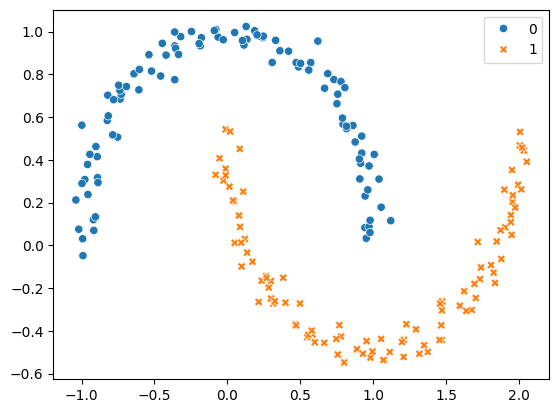

In [84]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05)

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)


In [85]:
classification_dataset = \
torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), \
                               torch.tensor(y, dtype=torch.long))

training_loader = DataLoader(classification_dataset)


In [86]:
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)


#H.	Classification Loss Function and Activation Function

In [87]:
x1 = torch.tensor([1.0, 2.0, 4.0])
x2 = torch.tensor([-3.0, -2.0, -1.0])

print("Softmax(x1):", F.softmax(x1, dim=0))
print("Softmax(x2):", F.softmax(x2, dim=0))


Softmax(x1): tensor([0.0420, 0.1142, 0.8438])
Softmax(x2): tensor([0.0900, 0.2447, 0.6652])


In [88]:
loss_func = nn.CrossEntropyLoss()


In [89]:

# Define a small feed-forward network for classification
model = nn.Sequential(
    nn.Linear(2, 10),  # Input layer (2 features) -> hidden layer (10 neurons)
    nn.Tanh(),         # Activation function
    nn.Linear(10, 2)   # Output layer (2 classes)
)

# Define the loss function for classification
loss_func = nn.CrossEntropyLoss()

In [90]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    for X_batch, y_batch in training_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.2719
Epoch 10 | Loss: 0.4020
Epoch 20 | Loss: 0.4467
Epoch 30 | Loss: 0.4187
Epoch 40 | Loss: 0.3602
Epoch 50 | Loss: 0.2851
Epoch 60 | Loss: 0.2232
Epoch 70 | Loss: 0.1772
Epoch 80 | Loss: 0.1427
Epoch 90 | Loss: 0.1165


In [91]:
# with torch.no_grad():
#     logits = model(torch.tensor(X, dtype=torch.float32))  # raw outputs
#     probs = torch.softmax(logits, dim=1)  # convert to probabilities
#     preds = torch.argmax(probs, dim=1)    # pick class with highest prob

#I.	Training a Classification Network

In [92]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

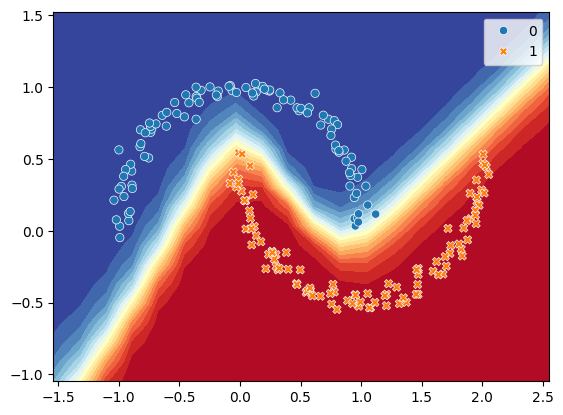

In [93]:
def visualize2DSoftmax(X, y, model, title=None):
  x_min = np.min(X[:,0])-0.5
  x_max = np.max(X[:,0])+0.5
  y_min = np.min(X[:,1])-0.5
  y_max = np.max(X[:,1])+0.5

  xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20),\
                       np.linspace(y_min, y_max, num=20), indexing='ij')
  xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))

  with torch.no_grad():
    logits = model(torch.tensor(xy_v, dtype=torch.float32))
    y_hat = F.softmax(logits, dim=1).numpy()

  cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20),\
                    levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
  ax = plt.gca()
  sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)

  if title is not None:
    ax.set_title(title)

visualize2DSoftmax(X, y, model)


In [94]:
model = nn.Sequential(
nn.Linear(2, 30),
nn.Tanh(),
nn.Linear(30, 30),
nn.Tanh(),
nn.Linear(30, 2),
)

train_simple_network(model, loss_func, training_loader, epochs=250)


Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

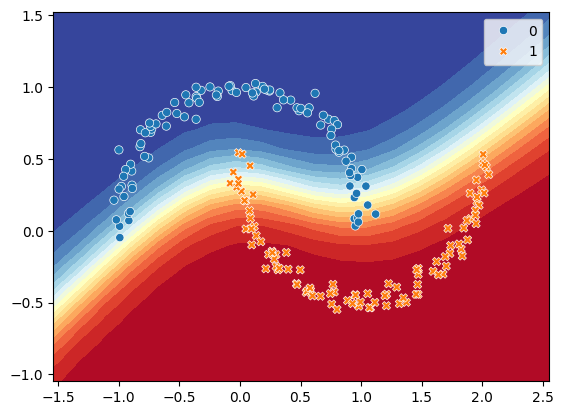

In [95]:
visualize2DSoftmax(X, y, model)